# Minipset 1: Adaptive Sampling
## Due Wednesday, April 29, 11:59 p.m.

In this problem set, you'll implement both the ETC and UCB algorithms to solve a simplified version of the VIPER sampling problem. You will also graph and evaluate the performances of the two algorithms with different parameters.

1. [Introduction](#introduction)
2. [ETC Implementation (30 pts)](#etc)
3. [ETC Discussion (10 pts)](#discussion-etc)
4. [UCB Implementation (40 pts)](#ucb)
5. [UCB Discussion (10 pts)](#discussion-ucb)
6. [Final Discussion (10 pts)](#conclusions)

Make sure you load the dependencies below by highlighting the cell below and pressing Shift + Enter.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

class BernoulliDist():
    """
    A class representing a bernouli distribution
    """
    def __init__(self, p):
        self.p = p
        self.rv = bernoulli(p)
        
    def sample(self):
        return self.rv.rvs()

    
class BanditProblem:
    """
    A class representing a bandit problem
    """
    def __init__(self, reward_dists=[]):
        """
        Initialize a bandit problem class
        
        Parameters:
        reward_dists: a list of BernouliDist representing reward distributions.
        """
        self.reward_dists = reward_dists
    
    def get_reward(self, action_index):
        """
        Return the reward for the action
        """
        return self.reward_dists[action_index].sample()

    def get_num_actions(self):
        """
        Return the number of available actions
        """
        return len(self.reward_dists)

    
def make_bernouli_bandit_problem(p_values):
    """
    Generate a BanditProblem with Bernouli reward distributions
    """
    dists = [BernoulliDist(x) for x in p_values]
    bp = BanditProblem(dists)
    return bp




# progress bar
# credit: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
def plot_etc(k, n, etc_func):
    assert(k >= 2)

    trials = 100 # monte carlo runs
    if n >= 100:
        trials = 50
    if n >= 250:
        trials = 30
    m_values = [i+1 for i in range(n//k)]
    
    best_arm_p_value = 0.9
    epsilon = 0.2
    p_values = [max(random.random()-epsilon, 0) for x in range(k)]
    temp = random.choice(p_values)
    p_values[p_values.index(temp)] = best_arm_p_value
    print("Ground truth p values (for your reference): ", p_values)
    time.sleep(2)
    
    reward_dists = [BernoulliDist(p) for p in p_values]
    bp = BanditProblem(reward_dists)

    rewards = []
    for i in range(len(m_values)):
        m = m_values[i]
        c_reward = 0
        for _ in range(trials):
            r, _ = etc_func(m, n, bp)
            c_reward += r
        rewards.append(c_reward / trials)
        update_progress(i / ( len(m_values) - 1))

    # plot the rewards
    plt.plot(m_values, rewards, linewidth=2.0)
    plt.title('Total Reward Obtained Over '+str(n)+' Samples with '+str(k)+' Zones')
    plt.xlabel('m')
    plt.ylabel('Reward')
    plt.grid(True)
    
def plot_ucb(k, n, ucb_func):
    trials = 50 # monte carlo runs
    if n > 100:
        trials = 20
    if n > 1000:
        trials = 5
    
    delta_values = list(np.linspace(0.01,0.99,99))

    best_arm_p_value = 0.9
    epsilon = 0.2
    p_values = [max(random.random()-epsilon, 0) for x in range(k)]
    temp = random.choice(p_values)
    p_values[p_values.index(temp)] = best_arm_p_value
    print("Ground truth p values (for your reference): ", p_values)
    time.sleep(2)
    
    reward_dists = [BernoulliDist(p) for p in p_values]
    bp = BanditProblem(reward_dists)

    rewards = []
    for i in range(99):
        delta = delta_values[i]
        c_reward = 0
        for trial in range(trials):
            r, a = ucb_func(delta, n, bp)
            c_reward += r
        rewards.append(c_reward / trials)
        update_progress(i / 99)

    # plot the rewards
    plt.plot(delta_values, rewards, linewidth=2.0)
    plt.title('Total Reward Obtained Over '+str(n)+' Samples with '+str(k)+' Zones')
    plt.xlabel('delta')
    plt.ylabel('Reward')
    plt.grid(True)

class DeterministicDist():
    """
    A deterministic distribution
    """
    def __init__(self, r):
        self.r = r
        
    def sample(self):
        return self.r

def test_ok():
    """If execution gets to this point, print out a happy message."""
    try:
        from IPython.display import display_html
        display_html("""<div class="alert alert-success">
        <strong>Tests passed!!</strong>
        </div>""", raw=True)
    except:
        print("Tests passed!!")
    
def check_results(reward, policy, exp_reward, exp_policy):
    if reward != exp_reward:
        raise Exception("Wrong total rewards! Output: {0} Should be: {1}.".format(reward, exp_reward))
        
    if policy != exp_policy:
        raise Exception("Wrong policy! Output: {0} Should be: {1}.".format(policy, exp_policy))
    
def test_etc(etc_func):
    """
    Testing function for ETC algorithm
    """
    # Case 1: 2 arm, action 1 best
    reward_dist = [DeterministicDist(0), DeterministicDist(1)]
    bp = BanditProblem(reward_dist)
    reward, best_action = etc_func(1, 10, bp)
    check_results(reward, best_action, 9, 1)
    
    # Case 2: 2 arm, action 0 best
    reward_dist = [DeterministicDist(10), DeterministicDist(1)]
    bp = BanditProblem(reward_dist)
    reward, best_action = etc_func(1, 10, bp)
    check_results(reward, best_action, 91, 0)
    
    # Case 3: 11 arms, random values, 20 rounds
    n = 20
    exp_values = [random.randrange(1, 10, 1) for i in range(10)]
    exp_values.append(12)
    exp_reward = sum(exp_values) + (n-11)*12
    reward_dist = [DeterministicDist(x) for x in exp_values]
    bp = BanditProblem(reward_dist)
    reward, best_action = etc_func(1, n, bp)
    check_results(reward, best_action, exp_reward, 10)
    
    test_ok()
    
def test_ucb(ucb_func):
    """
    Testing function for UCB algorithm
    For now, generates random problems with Deterministic Rewards
        and compares solution code output to user's output
    """
    for test in range(3):
        n = np.random.randint(30,60)
        delta = np.random.rand()
        exp_values = [random.randrange(1, 3, 1) for i in range(2)]
        
        best_index = exp_values.index(random.choice(exp_values))
        exp_values[best_index] = max(exp_values)+20
  
        reward_dist = [DeterministicDist(x) for x in exp_values]
        bp = BanditProblem(reward_dist)
        
        reward, best_action = ucb_func(delta, n, bp)
        
        assert(best_action == best_index)

    test_ok()

%matplotlib inline

# Introduction  <a id="introduction"/>

Welcome to the Moon!  It's 2023 and you and your team at NASA have just watched VIPER land on the South Pole of the moon. 

![VIPER](viper.jpg)

In this Pset, you will help VIPER determine the best location for finding water using the Bandit Algorithms Explore-Then-Commit (ETC) and Upper Confidence Bound Analysis (UCB).

Next year humans will be landing here, and it is your job to decide where the best landing site is. You need to find the location with the highest probability of having water so that the astronauts will have water to drink and to convert into fuel for the trip back home.  

VIPER has been designed to detect water with its onboard instruments with a definitive **yes** or **no**. Therefore, you can use a **Bernoulli** distribution to represent the reward at any given zone on the moon. Below you will find the map of accessible regions that VIPER is going to explore. VIPER will travel around the south pole of the moon, avoiding craters and areas of perpetual darkness. However, VIPER has a limited battery and needs to be back at the landing site before the long lunar night to make sure its battery doesn't die. Hence, you need to use adaptive sampling algorithms to figure out the best location within a specific time horizon.

![MoonMap](MoonMap.jpg)

A great technological advancement that you should know about since 2020 - VIPER actually **beams** to each location such that the time it takes to get to a nearby zone is the same as it takes to get to one at the far edge of your map (all zones are 1 time unit away such that each action takes 1 of your time units). Additionally, you should assume that finding water in a particular zone at one timestep will not impact finding water at the same zone in a future timestep. 

## More on Bernouli Distributions <a id="bernoulli-details"/>

In the context of this problem, when we visit a zone and take a sample, we either find water or we don't. Our samples come from a Bernoulli distribution. A Bernoulli distribution has a single parameter: $$0 \leq p \leq 1$$

The distribution returns 1 with probability $p$ and 0 with probability $(1-p)$. Your algorithms below will try to estimate the $p$ values of each zone and develop an optimal strategy to get the most possible water samples over a fixed horizon.

## Starter Code

In `utils.py` file, a `BernoulliDist` class is provided. It represents a Bernoulli distribution with parameter `p`.

A `BanditProblem` class is provided in the same file. It takes in a list of `BernoulliDist`, and has the following methods:
- `get_reward(action_index)`: Execute action with the provided index and return a reward based on the underlying Bernoullli distributions.
- `get_num_actions()`: Return the total number of actions available.

# ETC (30 points) <a id="etc"/>

First, let's have VIPER try Explore-Then-Commit (ETC) to find water on the moon. In ETC, we first sample every zone for $m$ rounds, and then commit to the best zone for the remaining rounds of our fixed $n$ horizon

For your convenience, here is the pseudo code for the ETC algorithm.
1.   Keep track of the reward from each zone individually. Initialize to 0 for all actions.
2.   Visit each zone $m$ times, adding the reward to the running total for that zone
3.   Identify the zone with the highest reward total.
We assume this zone to have the highest expected probability of finding water.
4.   Commit to this zone for the remaining $(n-mk)$ turns.
5.   Return the total earned reward over all $n$ turns

Here are some tips for implementing the ETC algorithm:
1.   To get the number of zones $k$, use `problem.get_num_actions()`.
2.   Zones are indexed 0 through $(k-1)$. To sample zone $i$, use `problem.get_reward(i)`.
3.   The order in which zones are sampled does not matter.

<div class="alert alert-info">
Implement the ETC algorithm below. 
</div>

In [2]:
def explore_then_commit(m, n, problem):
    """
    Function for the Explore-Then-Commit (ETC) algorithm.

    Input parameters:
    
    m: an integer (>0) that indicates the number of rounds per arm this algorithm 
        explores before choosing a best single action.
    
    n: horizon of play

    problem: a BanditProblem class
    
    Returns:
    tuple of (total reward, index of the best action in the problem)
    """
    ### BEGIN TEAM SOLUTION
    # number of actions
    k = problem.get_num_actions()

    # total rewards obtained from each action in the exploration phase
    rewards_per_action = [0]*k

    # total rewards
    total_rewards = 0
    
    # exploration phase
    for exp in range(m):
        for action in range(k):
            # sample action
            reward = problem.get_reward(action)
            rewards_per_action[action] += reward
            total_rewards += reward
    
    # optimize policy
    best_action = rewards_per_action.index(max(rewards_per_action))
    
    # exploitation phase
    for t in range(n-m*k):
        total_rewards += problem.get_reward(best_action)
    
    return total_rewards, best_action
    ### END TEAM SOLUTION

Run the cell below to test your ETC algorithm

In [3]:
test_etc(explore_then_commit)

Tests passed!!

Our problem is defined by the horizon $n$, the number of actions/zones $k$, and the underlying reward probability distributions of the zones. When we craft an ETC algorithm we have to choose the value of our parameter $m$, which decides how many times we sample each zone to estimate which zone has the highest probability of giving water before committing to that zone.

Below, we will create some plots that show how the setting of $m$ influences our final total reward. Set some different $k$ and $n$ values below and then run the following cell to see how the optimal $m$ changes. We suggest the following cases:
1. Fix $k$ = 2, test $n$ = 50, 100, 250, 500
2. Fix $n$ = 500, test $k$ = 5, 10, 15

**Notes:** 
- Don't be alarmed by non-integer rewards, we average the results of many trials.
- We run less trials for n values above 100 (to save time for you), so the curves may look less smooth than you expect.

In [4]:
k = 2 # set the number of zones here
n = 50 # set the horizon (total number of samples we take) here

Progress: [####################] 100.0%


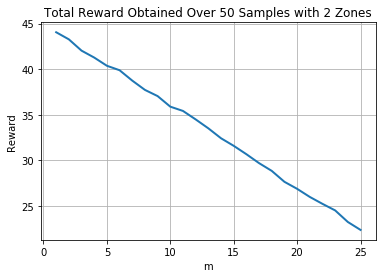

In [5]:
# Run this cell to see our final total number of water samples obtained over a range of m-values
plot_etc(k, n, explore_then_commit)

## ETC Discussion (10 points) <a id="discussion-etc"/>
Looking at the graph, what is the general trend in the total reward we get from ETC as we grow our number of exploration rounds $m$? Why do you think this is?

####### TEAM SOLUTION

1. Total reward should increase, then drecrease, resulting in a plot with a maximum total reward somewhere in the middle.
2. The more we explore, the more we know about the action reward distributions, but the fewer rounds we have to exploit the best action.

Note: depending on their implementation, it may default to select the first action if all actions return the same rewards. In that case, if the first action is actually the best action, the plot will just be a straight line with negative slope.

Based on your findings, does changing $k$ systematically affect our optimal value of $m$? If so, how? How about changing $n$?

####### TEAM SOLUTION

1. Changing $k$: no significant influence.
2. Changing $n$: with bigger $n$, the optimal $m$ will slightly increase (only visible if the students plot with very large number of $n$).

# UCB (40 points) <a id="ucb"/>

Next, let's try the Upper Confidence bound approach. With UCB, we optimistically play the arm that we think will give us the best reward based on its confidence bounds. The mathematical formulas used for UCB can be found in the lecture slides.

The parameter $\delta$ in the UCB algorithm puts a bound on the probability that we underestimate the true expected reward of an action at the end of our horizon.

For your convenience, the UCB psuedocode is as follows, where $t$ is the current timestep:
1. Choose each action once (rounds $t=1$ to $t=K$).
2. Determine the UCB for each arm using $\hat{u}$ and $\delta$.
3. While $t$ < $n$:
    1. Select the arm with the highest UCB and play this action.
    2. Update and re-calculate the UCB for this arm.

**Implement the UCB algorithm below**. Here are some tips:
1.   Use `np.sqrt()` to take square root and `np.log()` to take the log of a value.
2.   It may be helpful to keep and update multiple arrays with parameters of the various actions (upper confidence bound takes a few things into account). Feel free to include helper functions if necessary.

In [6]:
def ucb(delta, n, problem):
    """
    Function for the Upper Confindence Bound (UCB) algorithm.

    Input parameters:
    
    delta: an decimal value (0<delta<1) that bounds the probability that 
        UCB underestimates the expected reward of any action.
    
    n: horizon of play

    problem: a BanditProblem class
    
    Returns:
    tuple of (total reward, index of the best action in the problem)
    """
    ### BEGIN TEAM SOLUTION
    # number of actions
    k = problem.get_num_actions()
    
    # number of plays of each action
    num_plays = [0]*k
    
    # total rewards obtained from each action
    total_rewards = [0]*k
    
    # ucb for each action
    ucb = [0]*k
    
    def update(action):
        num_plays[action] += 1
        total_rewards[action] += problem.get_reward(action)
        empirical_mean = total_rewards[action]/num_plays[action]
        ucb[action] = empirical_mean + np.sqrt(2*np.log(1/delta)/num_plays[action])
    
    # preliminary exploration round
    for action in range(k):
        update(action)
        
    # remaining rounds
    for t in range(n-k):
        action = ucb.index(max(ucb))
        update(action)
        
    return sum(total_rewards), ucb.index(max(ucb))
    ### END TEAM SOLUTION

Run the cell below to test your ETC algorithm

In [7]:
test_ucb(ucb)

Tests passed!!

We will create some plots that show how the setting of our 'underestimation bound' delta influences our final total reward. Set some different $k$ and $n$ values below and then run the following cell to see how the optimal delta changes. 

We recommend the following cases:
1. Fix $k$ = 2, test $n$ = 100, 1000, 5000
2. Fix $n$ = 1000, test $k$ = 10, 15, 20

**Notes:** 
- Don't be alarmed by non-integer rewards, we average the results of multiple trials
- We run less trials as $n$ increases (to save time for you), so the curves may look less smooth for larger horizons.
- The changes to the number of trials are specifically tailored to follow the recommended horizon settings.
- Don't worry if you don't see any clear trends here, the regret bounds on UCB do not hold as tightly for small horizons. Do the best you can :)

In [8]:
k = 2 # set the number of zones here
n = 100 # set the horizon (total number of samples we take) here

Progress: [####################] 99.0%


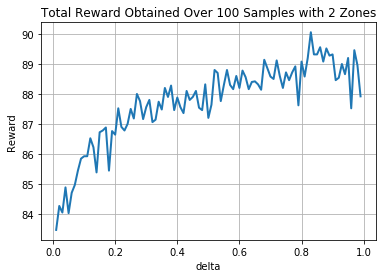

In [9]:
# Run this cell to see our final total number of water samples obtained over a range of delta-values
plot_ucb(k, n, ucb)

## UCB Discussion (10 points) <a id="discussion-ucb"/>
What does the parameter $\delta$ tell us about the behavior of our UCB algorithm? Looking at the graph, what is the general trend in the total reward we get from UCB as $\delta$ goes from 0 to 1? Why do you think this is?


####### TEAM SOLUTION

1. $\delta$ is approximately an upper bound on the probability of the event that the UCB value is an underestimate of the true mean. 
2. General trend: there should be an optimal value of $\delta$ somewhere between 0 and 1 that has the greatest total rewards.
3. Given the fixed number of rounds, we don't want to be too optimistic so that we waste too much time on exploring potentially good actions. 

Try graphing with different numbers of zones $k$. Does changing $k$ affect our optimal value of $\delta$?

####### TEAM SOLUTION

1. There should be neligible effects of $k$ on the optimal value of $\delta$.

## Final Discussion (10 points) <a id="conclusions"/>
Can you think of any reasons or situations in which ETC might be preferrable to UCB or vice-versa? Discuss below.

####### TEAM SOLUTION

1. If we have the ability to tune the value of $m$ for ETC, then it is possible that it might outperform UCB.
2. UCB should generally perform well enough without significant tuning.

Anything that is reasonable.